In [1]:
# Initial imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
from pathlib import Path
import requests

%matplotlib inline

In [4]:
SQ_csv = Path("../SaaS_Data/Square_SQ.csv")

In [5]:
SQ_df = pd.read_csv(SQ_csv, index_col='Date', infer_datetime_format=True, parse_dates=True)

In [6]:
SQ_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-08-15,74.489998,75.449997,71.450996,72.239998,72.239998,13050900
2018-08-16,73.400002,73.430000,71.599998,72.760002,72.760002,8175200
2018-08-17,72.830002,73.389999,71.801003,72.900002,72.900002,5561400
2018-08-20,72.949997,74.400002,72.010002,74.260002,74.260002,7076700
2018-08-21,74.260002,76.309998,74.260002,75.190002,75.190002,8587800


In [7]:
SQ_df.sort_index(ascending=True, inplace=True)

In [8]:
SQ_df = SQ_df.rename(columns={'Close': 'Close'})
SQ_df = SQ_df[['Close']]
SQ_df

,Close
Date,
2018-08-15,72.239998
2018-08-16,72.760002
2018-08-17,72.900002
2018-08-20,74.260002
2018-08-21,75.190002
...,...
2021-08-09,279.730011
2021-08-10,273.079987
2021-08-11,271.089996


In [9]:
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window-1):
        features = df.iloc[i : (i+window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [10]:
window_size = 100
feature_column = 0
target_column = 0

X, y = window_data(SQ_df, window_size, feature_column, target_column)

print(f"X sample values:\n{X[:3]} \n")
print(f"y sample values:\n{y[:3]}")

X sample values:
[[72.239998 72.760002 72.900002 74.260002 75.190002 76.440002 77.120003
  78.18     78.25     80.800003 85.699997 87.760002 88.639999 91.25
  87.199997 88.540001 89.970001 89.389999 92.279999 90.440002 90.220001
  90.82     86.860001 87.989998 84.800003 86.510002 85.300003 86.040001
  95.349998 94.650002 97.959999 99.010002 97.279999 97.830002 96.959999
  94.489998 94.110001 86.059998 86.169998 77.449997 69.029999 73.970001
  73.769997 78.720001 78.050003 74.959999 74.07     75.720001 74.150002
  69.339996 73.489998 71.120003 67.279999 68.760002 73.449997 76.739998
  77.760002 75.010002 77.309998 82.690002 75.230003 73.269997 69.830002
  71.849998 69.809998 73.599998 70.589996 62.970001 61.82     62.619999
  63.470001 66.519997 65.879997 69.889999 69.900002 69.839996 71.949997
  63.509998 65.690002 60.779999 63.380001 61.779999 63.650002 62.900002
  62.139999 58.619999 59.919998 59.029999 55.900002 52.509998 50.720001
  55.32     56.150002 55.869999 56.09     57.200001

In [11]:
split = int(0.6 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [12]:
y_train

array([[ 65.93    ],
       [ 66.099998],
       [ 66.230003],
       [ 65.18    ],
       [ 65.959999],
       [ 65.900002],
       [ 68.839996],
       [ 72.239998],
       [ 67.849998],
       [ 69.099998],
       [ 73.940002],
       [ 77.970001],
       [ 76.220001],
       [ 68.559998],
       [ 71.529999],
       [ 71.349998],
       [ 70.800003],
       [ 71.75    ],
       [ 72.279999],
       [ 72.669998],
       [ 71.949997],
       [ 73.489998],
       [ 74.32    ],
       [ 75.589996],
       [ 75.629997],
       [ 75.669998],
       [ 75.639999],
       [ 76.639999],
       [ 75.970001],
       [ 74.43    ],
       [ 76.080002],
       [ 77.129997],
       [ 77.949997],
       [ 79.32    ],
       [ 81.239998],
       [ 77.459999],
       [ 74.690002],
       [ 76.040001],
       [ 75.139999],
       [ 74.110001],
       [ 74.400002],
       [ 75.529999],
       [ 76.769997],
       [ 77.849998],
       [ 77.379997],
       [ 76.650002],
       [ 75.230003],
       [ 76.8

In [13]:
# Import MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

x_train_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()

x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

X_test = x_train_scaler.transform(X_test)
y_test = y_train_scaler.transform(y_test)

In [14]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [16]:
model = Sequential()

number_units = window_size
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units = number_units,
    return_sequences = True,
    input_shape= (X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(
    units = number_units,
    return_sequences = True
    ))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(
    units = number_units
    ))
model.add(Dropout(dropout_fraction))

# Output Layer
model.add(Dense(1))

In [17]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 100)          40800     
_________________________________________________________________
dropout (Dropout)            (None, 100, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 100)          80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [18]:
model.fit(X_train, y_train, epochs=20, shuffle=False, batch_size=100, verbose=1)

Epoch 1/20
4/4 [==============================] - 9s 489ms/step - loss: 0.0462
Epoch 2/20
4/4 [==============================] - 2s 483ms/step - loss: 0.0370
Epoch 3/20
4/4 [==============================] - 2s 519ms/step - loss: 0.0225
Epoch 4/20
4/4 [==============================] - 2s 511ms/step - loss: 0.0114
Epoch 5/20
4/4 [==============================] - 2s 534ms/step - loss: 0.0167
Epoch 6/20
4/4 [==============================] - 2s 535ms/step - loss: 0.0121
Epoch 7/20
4/4 [==============================] - 2s 540ms/step - loss: 0.0101
Epoch 8/20
4/4 [==============================] - 2s 551ms/step - loss: 0.0082
Epoch 9/20
4/4 [==============================] - 2s 535ms/step - loss: 0.0098
Epoch 10/20
4/4 [==============================] - 2s 518ms/step - loss: 0.0074
Epoch 11/20
4/4 [==============================] - 2s 578ms/step - loss: 0.0063
Epoch 12/20
4/4 [==============================] - 2s 509ms/step - loss: 0.0060
Epoch 13/20
4/4 [==============================] 

In [19]:
model.evaluate(X_test, y_test, verbose=0)

0.05053519457578659

In [20]:
predicted = model.predict(X_test)

In [21]:
predicted_prices = y_train_scaler.inverse_transform(predicted)

In [22]:
real_prices = y_train_scaler.inverse_transform(y_test.reshape(-1,1))

In [23]:
SQ_actual_predicted = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = SQ_df.index[-len(real_prices): ])

SQ_actual_predicted.head()

,Actual,Predicted
Date,,
2020-07-31,129.130005,126.587616
2020-08-03,129.850006,125.787766
2020-08-04,134.800003,125.160149
2020-08-05,136.830002,124.847519
2020-08-06,146.550003,124.958588


In [24]:
SQ_actual_predicted.tail()

,Actual,Predicted
Date,,
2021-08-09,275.100006,276.007538
2021-08-10,279.730011,279.215942
2021-08-11,273.079987,282.660065
2021-08-12,271.089996,286.106293
2021-08-13,268.589996,289.355408


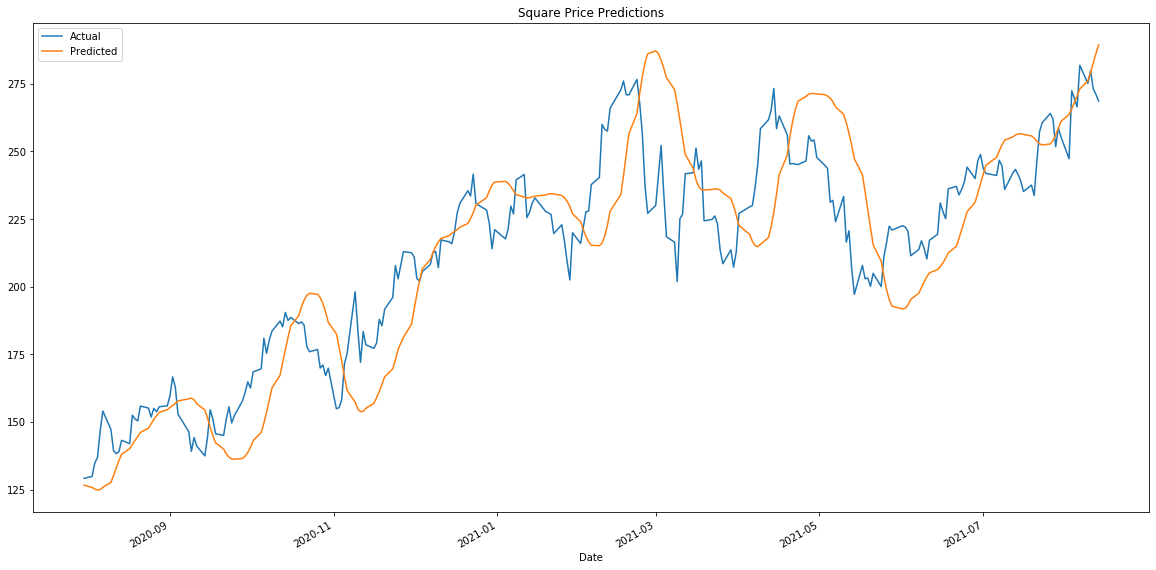

In [25]:
SQ_actual_predicted.plot(figsize=(20,10), title="Square Price Predictions")